In [1]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nimfa
from sklearn.decomposition import NMF
from nimfa.methods.seeding.nndsvd import Nndsvd
import pandas as pd
import scanpy as sc
import anndata

ptSize = 10

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

In [32]:
moudata = np.load('5 x_mou_0902_anno_nn.npz', allow_pickle=True)
x_mou = moudata['x'].item().toarray()
y_mou = moudata['y']

humdata = np.load('5 x_hum_0902_anno_nn.npz', allow_pickle=True)
x_hum = humdata['x'].item().toarray()
y_hum = humdata['y']

In [33]:
Ws = []
Hs = []
#for r in range(2,11):
for r in np.arange(5,61,5):
    s = Nndsvd()
    w,h = s.initialize(x_mou, rank = r, options = {'flag':0})

    lsnmf = nimfa.Lsnmf(V=x_mou, seed=None,rank=r, W=w, H=h)
    lsnmf_fit = lsnmf()
    W = lsnmf_fit.basis()
    H = lsnmf_fit.coef()

    Ws.append(W)
    Hs.append(H)

    #W_norm = normalize(W, axis=1, norm='l1')

In [34]:
pd.to_pickle(Ws, '6 Ws_mou_0902')
pd.to_pickle(Hs, '6 Hs_mou_0902')

In [35]:
def entropy(M):
    M_ = np.multiply(M, np.log2(M))
    return np.sum(M_)

def sparseness(M, r):
    s = np.linalg.norm(M, axis=1)
    a = 1./np.sqrt(r)
    return (s - a)/(1 - a)

([<matplotlib.axis.XTick at 0x7f6160396820>,
 [Text(1, 0, '5'),
  Text(2, 0, '10'),
  Text(3, 0, '15'),
  Text(4, 0, '20'),
  Text(5, 0, '25'),
  Text(6, 0, '30'),
  Text(7, 0, '35'),
  Text(8, 0, '40'),
  Text(9, 0, '45'),
  Text(10, 0, '50'),
  Text(11, 0, '55'),
  Text(12, 0, '60')])

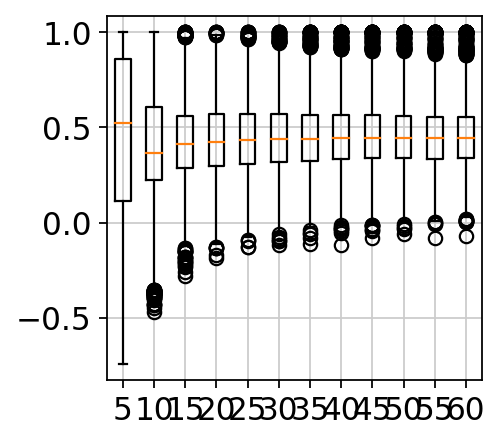

In [36]:
Ws_norm = [normalize(m, axis=1, norm='l1') for m in Ws]
spars = [sparseness(m, idx+2) for idx, m in enumerate(Ws_norm)]

plt.boxplot(spars)
plt.xticks(range(1,13), np.arange(5,61,5))

In [15]:
W_ref = Ws[1]
H_ref = Hs[1]
H_ref.shape

(10, 4313)

([<matplotlib.axis.XTick at 0x7f611a872340>,
 [Text(1, 0, '5'),
  Text(2, 0, '10'),
  Text(3, 0, '15'),
  Text(4, 0, '20'),
  Text(5, 0, '25'),
  Text(6, 0, '30'),
  Text(7, 0, '35'),
  Text(8, 0, '40'),
  Text(9, 0, '45'),
  Text(10, 0, '50'),
  Text(11, 0, '55'),
  Text(12, 0, '60')])

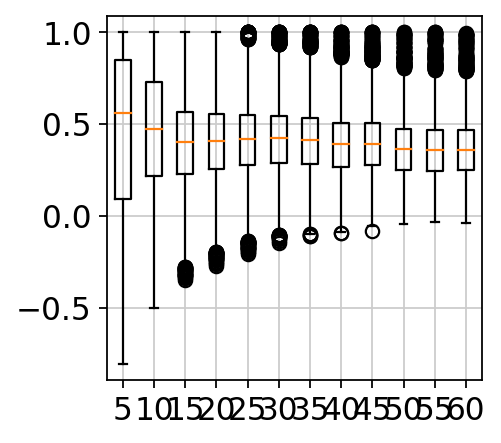

In [37]:
Ws = []
Hs = []
#for r in range(2,11):
for r in np.arange(5,61,5):
    s = Nndsvd()
    w,h = s.initialize(x_hum, rank = r, options = {'flag':0})

    lsnmf = nimfa.Lsnmf(V=x_hum, seed=None,rank=r, W=w, H=h)
    lsnmf_fit = lsnmf()
    W = lsnmf_fit.basis()
    H = lsnmf_fit.coef()

    Ws.append(W)
    Hs.append(H)

    #W_norm = normalize(W, axis=1, norm='l1')


Ws_norm = [normalize(m, axis=1, norm='l1') for m in Ws]
spars = [sparseness(m, idx+2) for idx, m in enumerate(Ws_norm)]
plt.boxplot(spars)
plt.xticks(range(1,13), np.arange(5,61,5))

In [38]:
pd.to_pickle(Ws, '6 Ws_hum_0902')
pd.to_pickle(Hs, '6 Hs_hum_0902')

In [16]:
W_tar = x_hum @ np.linalg.pinv(H_ref)
np.save('8 Wtar_0902', W_tar)
W_tar.shape

In [27]:
adata = anndata.read_h5ad('2 filtered_normalised_scaled_mou_0901.h5ad')
adata

AnnData object with n_obs × n_vars = 5512 × 16592
    obs: 'Specimen', 'Population', 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'source_colors'

In [28]:
sc.tl.pca(adata, use_highly_variable=True, svd_solver='arpack', n_comps=32, random_state=0)
adata

computing PCA
    on highly variable genes
    with n_comps=32
    finished (0:00:01)


AnnData object with n_obs × n_vars = 5512 × 16592
    obs: 'Specimen', 'Population', 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'source_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [36]:
adata.varm = None
adata.uns.pca = None

In [35]:
adata.obsm['X_pca'] = Ws[1]

In [37]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [38]:
adata_anno = sc.read_h5ad('3 clustered_mou_0831_anno.h5ad')

In [59]:
adata.obs['CellLabel'] = adata_anno.obs.CellLabel.to_numpy()

In [61]:
adata.obs.CellLabel = adata.obs.CellLabel.astype('category')

In [62]:
adata.obs['CellLabel']

M1_TBM_PCR2-4_altered_out_gene_exon_AGGCCATTGGGC     9
M1_TBM_PCR2-4_altered_out_gene_exon_GCTGGATCGCTT     5
M1_TBM_PCR2-4_altered_out_gene_exon_CGACTTATCTTC     9
M1_TBM_PCR2-4_altered_out_gene_exon_CTAATCTGTTAG     9
M1_TBM_PCR2-4_altered_out_gene_exon_AGTTATGGTTCG     9
                                                    ..
M3_DBM_PCR2-9_altered_out_gene_exon_TCTCGCTGGGGG    14
M3_DBM_PCR2-9_altered_out_gene_exon_GTTCCCGGCCAC     9
M3_DBM_PCR2-9_altered_out_gene_exon_GCGCACCAGATT     9
M3_DBM_PCR2-9_altered_out_gene_exon_TCCCAATAGGTG     9
M3_DBM_PCR2-9_altered_out_gene_exon_GATTTGTTGAGA     9
Name: CellLabel, Length: 5512, dtype: category
Categories (14, int64): [1, 2, 3, 4, ..., 11, 12, 13, 14]

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:19)


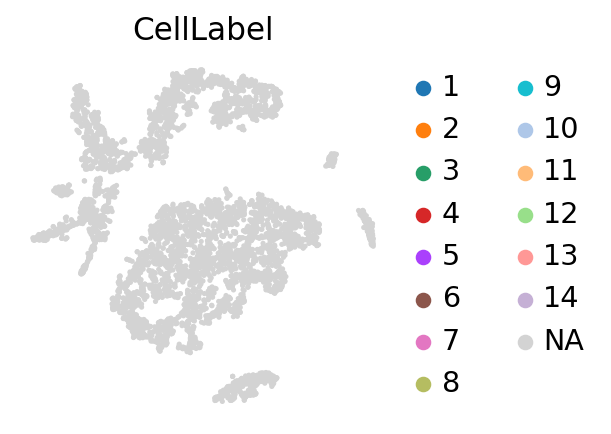

In [42]:
sc.tl.tsne(adata, use_rep='X_pca', n_pcs=10, random_state=0)


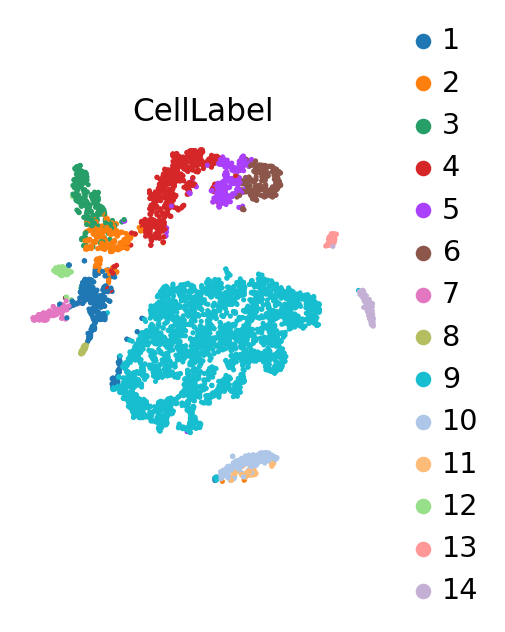

In [65]:
sc.pl.tsne(adata, use_raw=False, layer='X_pca', color='CellLabel')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


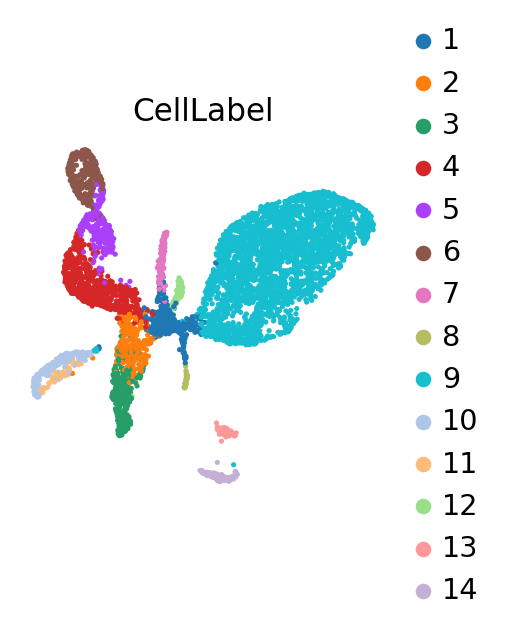

In [64]:
sc.tl.umap(adata)
sc.pl.umap(adata, use_raw=False, layer='X_pca', color='CellLabel')

In [67]:
y_mou.shape

(5512,)

In [68]:
# non negative
x_mouse = Ws[1]
np.savez_compressed('8 x_mou_0902_nn.npz', x = x_mouse, y = y_mou)

x_hum = W_tar
np.savez_compressed('8 x_hum_0902_nn.npz', x = x_hum, y = y_hum)

# No transfer hum W

In [76]:
x_hum = Ws[1]
np.savez_compressed('8 x_hum_0902_notrans.npz', x = x_hum, y = y_hum)
pd.to_pickle(Ws, '8 Ws_hum_0902')
pd.to_pickle(Hs, '8 Hs_hum_0902')

In [75]:
Ws[1].shape

(9417, 10)